# Augmentation Methodology
The following describes the methodology used to augment the driver information, given that we are going to collapse the data into a frame with single rows per driver. Since we will be inherently losing information by collapsing all of the rows, we will need to supplement the dataset with new columns.

## Temporal Data
Most of the temporal information will be lost when we collapse the rows, so we will need additional columns that summarize that info:

- Start date (first load)
- End date (most recent load)
- Longevity (how long the driver has been employed, according to this dataset)
- Trip Frequency (standard deviation or some measure of variance between trips)
- Load Delta (some standard measure of how many days between each load)
- Preferred weekday (the mode of the `weekday` column
- Normal weekday (the mean or median of the `weekday` column
- Weekday distribution (are the weekdays consistent?)

## Location Data

- Roaming (does the driver have more than one reported `home_base_city` or `home_base_state`?
- Preferred Trip Distance (Possibly use `interested_in_dryage` and `carrier_trucks` to determine a measure of how far the driver prefers to drive)

## Boolean Features

- Indecision (did this person apply to become a driver more than once?)

---

# Transformation Methodology

## Converting categoricals to boolean

The following columns have only two unique values, which are easily turned into boolean features:

- `dim_carrier_type` (**already implemented** corresponds to "is this a self-owned driver?", **0: Fleet, 1: Owner Operator**)
- `interested_in_drayage` (**already implemented** corresponds to "is this driver willing/able to complete drayage shipments?", **0: not specified, 1: yes**)
- `port_qualified` (**already implemented** corresponds to "is this driver qualified to handle port shipments?", **0: no, 1: yes**)
- `signup_source` (**already implemented** corresponds to "did this driver sign up on a mobile device?", **0: Other, 1: Mobile**)
- `driver_with_twic` (**already implemented** corresponds to "does this driver have TWIC insurance?" **0: no, 1: yes**)

## New boolean columns
- `dim_preferred_lanes` (**already implemented** corresponds to "does this driver have a route preference?" **0: null, 1: any**)

## One Hot Encoding Categoricals

The following columns have a limited number of unique categorical values that would work well with one-hot encoding

- `carrier_trucks` (**already implemented** 16 unique arrangements of trucks)
- `weekday` (**already implemented** -- pro: maintain all information for day of week, con: 7 extra columns, most of which will be sparse)
- `dim_preferred_lanes` (**not implemented yet** -- 53 unique values -- pro: this might actually mean something, con: it might mean absolutely nothing and will double the number of columns)

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import seaborn as sn
import datetime
import random
from datetime import date
from pprint import pprint
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
import statistics 
from statistics import mode

In [2]:
def convert_strings_to_dates(dataframe):
    frame = dataframe.copy()
    frame.dt = [date.fromisoformat(d) for d in frame.dt]
    frame.first_load_date = [date.fromisoformat(d) for d in frame.first_load_date]
    frame.most_recent_load_date = [date.fromisoformat(d) for d in frame.most_recent_load_date]
    frame.ts_signup = [datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S+00:00') for d in frame.ts_signup]
    frame.ts_signup = [date(year=d.year, month=d.month, day=d.day) for d in frame.ts_signup]
    return frame

In [3]:
def convert_date_to_int(dataframe):
    frame = dataframe.copy()
    conversion = lambda dt_time: 10000*dt_time.year + 100*dt_time.month + dt_time.day
    frame.dt = [conversion(d) for d in frame.dt]
    frame.ts_signup = [conversion(d) for d in frame.ts_signup]
    frame.first_load_date = [conversion(d) for d in frame.first_load_date]
    frame.most_recent_load_date = [conversion(d) for d in frame.most_recent_load_date]
    return frame

In [4]:
def aggregate_rows_by_driver_id(dataframe):
    '''
    Returns a new dataframe indexed by Driver ID using an optimal set of aggregations per column.
    This method will return a dataframe that only contains the columns listed below.
    Note: duplicate columns are inherently pruned (simply by not adding them below), so it is 
        safe to pass in the full dataframe and expect a pruned version in return. 
        Also note that the `id_driver` will now be the index of the dataframe and NOT its own column.
    '''
    minimum = 'min'
    maximum = 'max'
    median = 'median'
    random_mode = lambda x: random.choice(pd.Series.mode(x if isinstance(x, list) else list(x)))
    average = lambda x: pd.Series.mean(x)

    aggregation = {
        'dt': maximum,
        'weekday': random_mode,
        'dim_carrier_type': random_mode,
        'carrier_trucks': mode,
        'num_trucks': maximum,
        'interested_in_drayage': random_mode,
        'port_qualified': random_mode,
        'signup_source': random_mode,
        'ts_signup': maximum,
        'days_signup_to_approval': maximum,
        'driver_with_twic': mode,
        'dim_preferred_lanes': mode,
        'first_load_date': minimum,
        'most_recent_load_date': maximum,
        'loads': random_mode,
        'marketplace_loads_otr': maximum,
        'marketplace_loads_atlas': maximum,
        'marketplace_loads': maximum,
        'brokerage_loads_otr': maximum,
        'brokerage_loads_atlas': maximum,
        'brokerage_loads': maximum,
        'label': random_mode
    }

    return dataframe.groupby(['id_driver']).agg(aggregation)

In [5]:
def augment_boolean_columns(dataframe):
    frame = dataframe.copy()
    label_encoder = LabelEncoder()
    
    # Replacement (no new columns needed, just transform strings to 0 or 1)
    frame['interested_in_drayage'] = label_encoder.fit_transform(frame.interested_in_drayage)
    frame['port_qualified'] = label_encoder.fit_transform(frame.port_qualified)
    frame['driver_with_twic'] = label_encoder.fit_transform(frame.driver_with_twic)
    
    # Create new columns with more appropriate names, delete the old columns
    frame['self_owned'] = label_encoder.fit_transform(frame.dim_carrier_type)
    frame['mobile_signup'] = np.logical_xor(label_encoder.fit_transform(frame.signup_source), 1).astype(int)
    frame['has_route_preference'] = label_encoder.fit_transform(~frame.dim_preferred_lanes.isnull())
    frame.drop(columns=['dim_carrier_type', 'signup_source', 'dim_preferred_lanes'], inplace=True)
    
    return frame

In [6]:
def encode_categorical_columns(dataframe):
    frame = dataframe.copy()

    # Encode various truck types
    trucks = pd.get_dummies(frame.carrier_trucks)
    trucks.columns = ['truck-' + c.replace('[', '').replace(']', '').replace('"', '').replace(',', '').replace(' ', '-') for c in trucks.columns]
    
    # Encode the 7 different days of the week
    weekdays = pd.get_dummies(frame.weekday)
    weekdays.columns = [f'prefers-{x}'.lower() for x in weekdays.columns]
    
    # Drop the originals since they are no longer needed.
    frame.drop(columns=['carrier_trucks', 'weekday'], inplace=True)
    
    # Concatenate various new frames with the original and return
    result = pd.concat([frame, trucks, weekdays], axis=1)
    return result

In [7]:
def generate_labels(dataframe, loads_percentile, most_recent_percentile):
    label_encoder = LabelEncoder()
    frame = dataframe.copy()
    labels = (frame.total_loads >= loads_percentile) & (frame.most_recent_load_date >= most_recent_percentile)
    frame['label'] = label_encoder.fit_transform(labels)
#     frame.drop(columns=['total_loads', 'most_recent_load_date'], inplace=True)
    return frame

## Load CSV to DataFrame

In [8]:
df = pd.read_csv('training_dataset_V3.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83414 entries, 0 to 83413
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                83414 non-null  int64  
 1   dt                        83414 non-null  object 
 2   weekday                   83414 non-null  object 
 3   year                      83414 non-null  int64  
 4   id_driver                 83414 non-null  int64  
 5   id_carrier_number         83414 non-null  object 
 6   dim_carrier_type          83414 non-null  object 
 7   dim_carrier_company_name  83365 non-null  object 
 8   home_base_city            83369 non-null  object 
 9   home_base_state           83369 non-null  object 
 10  carrier_trucks            83414 non-null  object 
 11  num_trucks                83344 non-null  float64
 12  interested_in_drayage     83414 non-null  object 
 13  port_qualified            83414 non-null  object 
 14  signup

**Verify that no columns are duplicates**

In [9]:
for (columnName1, columnData1) in df.iteritems():
    for (columnName2, columnData2) in df.iteritems():
        if columnData1.equals(columnData2) and columnName1 is not columnName2:
            print(f'{columnName1} is equal to {columnName2}')

dt is equal to load_day
load_day is equal to dt


**Drops duplicates and unwanted columns**

In [10]:
df.drop(columns=['Unnamed: 0', 'load_day', 'ts_first_approved', 'dim_carrier_company_name', 'home_base_city', 'home_base_state', 'id_carrier_number', 'year'], inplace=True)
df.dropna(subset=['days_signup_to_approval', 'num_trucks'], inplace=True)

**Convert strings to dates for easier processing**

In [11]:
df = convert_strings_to_dates(df)

## Collapse DataFrame into single rows per driver

In [12]:
df2 = df.groupby(['id_driver']).agg('max')

In [13]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3936 entries, 30 to 38125
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   dt                       3936 non-null   object 
 1   weekday                  3936 non-null   object 
 2   dim_carrier_type         3936 non-null   object 
 3   carrier_trucks           3936 non-null   object 
 4   num_trucks               3936 non-null   float64
 5   interested_in_drayage    3936 non-null   object 
 6   port_qualified           3936 non-null   object 
 7   signup_source            3936 non-null   object 
 8   ts_signup                3936 non-null   object 
 9   days_signup_to_approval  3936 non-null   float64
 10  driver_with_twic         3936 non-null   object 
 11  dim_preferred_lanes      175 non-null    object 
 12  first_load_date          3936 non-null   object 
 13  most_recent_load_date    3936 non-null   object 
 14  loads                 

# Label Generation - Two Methods

There are (at least) two methods we can use to generate the target labels. One would consider the data *before* it has been collapsed, and the other would consider the data *after* it has been collapsed.

It seems to make sense to collapse the data before taking the 75th percentile of the `total_loads`, because otherwise you will be counting a bunch of drivers many times (as many times as they have rows in the dataset, since `total_loads` is cumulative, and the same value for each row for any given driver) and ignoring others.

In my opinion, using `most_recent_load_date` to determine a high-performance driver doesn't make that much sense, since clearly a driver can perform well and not have delivered a load within the last week or so. If we look at the original dateset, the 75th percentile of `most_recent_load_date` is 2021-02-14, which is just three days before the latest date, 2021-02-17. This means if a person happened to take a few days off, they would not be considered high-performing. However, if we use the *collapsed* dataset, then we're looking at 2020-05-19 as the 75th percentile. This is also problematic because it means that a driver might not have driven for nearly 9 months but would still be considered high-performance.

## 1 - Use the original dataset

The top 75th percentile of total_loads is >= 320.0


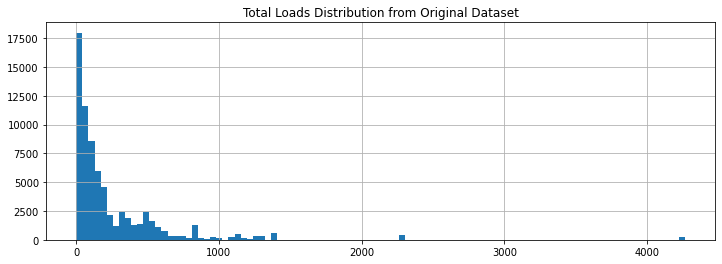

In [14]:
plt.figure(figsize=(12,4))
df.total_loads.hist(bins=100)
plt.title('Total Loads Distribution from Original Dataset')
top_loads = df.total_loads.quantile(0.75)
print(f'The top 75th percentile of total_loads is >= {top_loads}')

The top 75th percentile of most_recent_load_date falls on 2021-02-16


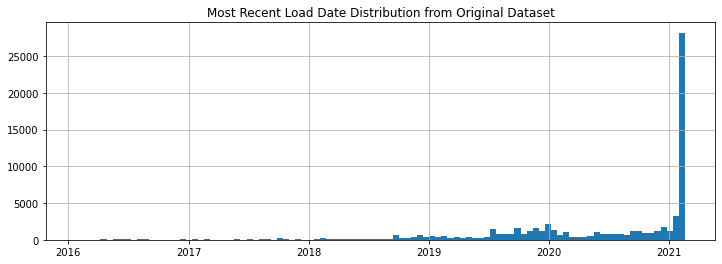

In [15]:
plt.figure(figsize=(12,4))
df.most_recent_load_date.hist(bins=100)
plt.title('Most Recent Load Date Distribution from Original Dataset')
top_most_recent = df.most_recent_load_date.quantile(0.75)
print(f'The top 75th percentile of most_recent_load_date falls on {top_most_recent}')

## 2 - Use the collapsed dataset

The top 75th percentile of total_loads is >= 22.0


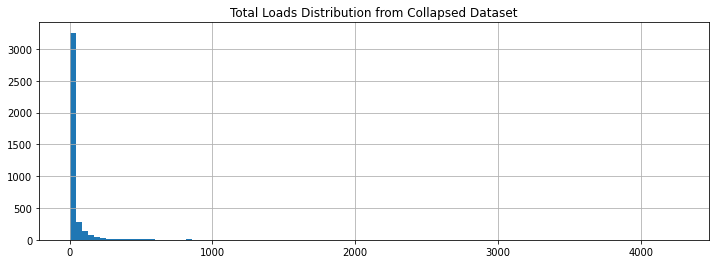

In [16]:
plt.figure(figsize=(12,4))
df2.total_loads.hist(bins=100)
plt.title('Total Loads Distribution from Collapsed Dataset')
top_loads = df2.total_loads.quantile(0.75)
print(f'The top 75th percentile of total_loads is >= {top_loads}')

The top 75th percentile of most_recent_load_date falls on 2020-08-25


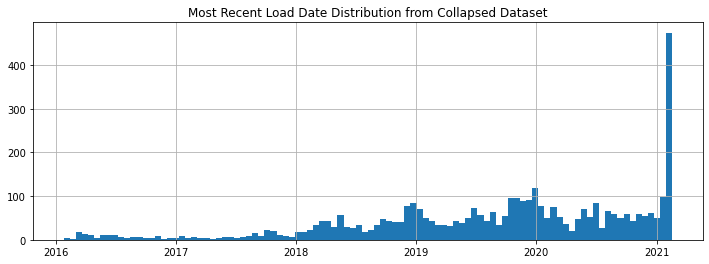

In [17]:
plt.figure(figsize=(12,4))
df2.most_recent_load_date.hist(bins=100)
plt.title('Most Recent Load Date Distribution from Collapsed Dataset')
top_most_recent = df2.most_recent_load_date.quantile(0.75)
print(f'The top 75th percentile of most_recent_load_date falls on {top_most_recent}')

# Let's run some tests...

- Method 1: `total_loads` from original, `most_recent_load_date` from original
- Method 2: `total_loads` from original, `most_recent_load_date` from collapsed
- Method 3: `total_loads` from collapsed, `most_recent_load_date` from original
- Method 4: `total_loads` from collapsed, `most_recent_load_date` from collapsed

In [18]:
df2 = df.groupby('id_driver').agg('max')

In [19]:
top_loads1 = df.total_loads.quantile(0.75)
top_loads2 = df2.total_loads.quantile(0.75)

top_most_recent1 = df.most_recent_load_date.quantile(0.75)
top_most_recent2 = df2.most_recent_load_date.quantile(0.75)

top_loads1, top_loads2, top_most_recent1, top_most_recent2

(320.0, 22.0, datetime.date(2021, 2, 16), datetime.date(2020, 8, 25))

In [20]:
top1 = df[(df.total_loads >= top_loads1) & (df.most_recent_load_date >= top_most_recent1)]
top2 = df[(df.total_loads >= top_loads1) & (df.most_recent_load_date >= top_most_recent2)]
top3 = df[(df.total_loads >= top_loads2) & (df.most_recent_load_date >= top_most_recent1)]
top4 = df[(df.total_loads >= top_loads2) & (df.most_recent_load_date >= top_most_recent2)]

In [21]:
n_datapoints = df.shape[0]
data1, data2, data3, data4 = top1.shape[0], top2.shape[0], top3.shape[0], top4.shape[0]
print(f'{(data1 / n_datapoints) * 100:.2f}% of samples considered high-performance using method 1 ({data1} rows)')
print(f'{(data2 / n_datapoints) * 100:.2f}% of samples considered high-performance using method 2 ({data2} rows)')
print(f'{(data3 / n_datapoints) * 100:.2f}% of samples considered high-performance using method 3 ({data3} rows)')
print(f'{(data4 / n_datapoints) * 100:.2f}% of samples considered high-performance using method 4 ({data4} rows)')

11.89% of samples considered high-performance using method 1 (8453 rows)
20.79% of samples considered high-performance using method 2 (14774 rows)
24.81% of samples considered high-performance using method 3 (17630 rows)
53.27% of samples considered high-performance using method 4 (37858 rows)


In [22]:
rows1 = top1.groupby(['id_driver']).agg('max').shape[0]
rows2 = top2.groupby(['id_driver']).agg('max').shape[0]
rows3 = top3.groupby(['id_driver']).agg('max').shape[0]
rows4 = top4.groupby(['id_driver']).agg('max').shape[0]

In [23]:
n_drivers = df2.shape[0]
print(f'{(rows1 / n_drivers) * 100:.2f}% of drivers considered high-performance using method 1 ({rows1} drivers)')
print(f'{(rows2 / n_drivers) * 100:.2f}% of drivers considered high-performance using method 2 ({rows2} drivers)')
print(f'{(rows3 / n_drivers) * 100:.2f}% of drivers considered high-performance using method 3 ({rows3} drivers)')
print(f'{(rows4 / n_drivers) * 100:.2f}% of drivers considered high-performance using method 4 ({rows4} drivers)')

1.19% of drivers considered high-performance using method 1 (47 drivers)
2.13% of drivers considered high-performance using method 2 (84 drivers)
6.17% of drivers considered high-performance using method 3 (243 drivers)
14.51% of drivers considered high-performance using method 4 (571 drivers)


# Results

- Method 1: Labels 12% of the data but only 1% of drivers
- Method 2: Labels 21% of the data but only 2% of drivers
- **Method 3: Labels 25% of the data and 6% of drivers**
- Method 4: Labels 53% of the data and 14.5% of drivers

---

# 1 - Generate Labels and 4 - Pipeline

`original_df` == Original data, labeled, with `total_loads` and `most_recent_load_date` removed.

`collapsed_df` == `original_df` aggregated by Driver ID

In [24]:
loads_75th_percentile = 22
most_recent_75th_percentile = date(year=2021, month=2, day=10)

In [25]:
original_df = generate_labels(df, top_loads2, top_most_recent1)
original_df = augment_boolean_columns(original_df)
original_df = encode_categorical_columns(original_df)
original_df = convert_date_to_int(original_df)
print(original_df.shape)
original_df.info()

(71072, 43)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 71072 entries, 0 to 83413
Data columns (total 43 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   dt                               71072 non-null  int64  
 1   id_driver                        71072 non-null  int64  
 2   num_trucks                       71072 non-null  float64
 3   interested_in_drayage            71072 non-null  int64  
 4   port_qualified                   71072 non-null  int64  
 5   ts_signup                        71072 non-null  int64  
 6   days_signup_to_approval          71072 non-null  float64
 7   driver_with_twic                 71072 non-null  int64  
 8   first_load_date                  71072 non-null  int64  
 9   most_recent_load_date            71072 non-null  int64  
 10  loads                            71072 non-null  int64  
 11  marketplace_loads_otr            71072 non-null  int64  
 12  market

In [26]:
driver_id_df = generate_labels(df, top_loads2, top_most_recent1)
driver_id_df = aggregate_rows_by_driver_id(driver_id_df)
driver_id_df = augment_boolean_columns(driver_id_df)
driver_id_df = encode_categorical_columns(driver_id_df)
driver_id_df = convert_date_to_int(driver_id_df)
print(driver_id_df.shape)
driver_id_df.info()

(3936, 41)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3936 entries, 30 to 38125
Data columns (total 41 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   dt                               3936 non-null   int64  
 1   num_trucks                       3936 non-null   float64
 2   interested_in_drayage            3936 non-null   int64  
 3   port_qualified                   3936 non-null   int64  
 4   ts_signup                        3936 non-null   int64  
 5   days_signup_to_approval          3936 non-null   float64
 6   driver_with_twic                 3936 non-null   int64  
 7   first_load_date                  3936 non-null   int64  
 8   most_recent_load_date            3936 non-null   int64  
 9   loads                            3936 non-null   int64  
 10  marketplace_loads_otr            3936 non-null   int64  
 11  marketplace_loads_atlas          3936 non-null   int64  
 12  marketp

# 3 - Statistical Analysis

In [27]:
original_df.describe()

,dt,id_driver,num_trucks,interested_in_drayage,port_qualified,ts_signup,days_signup_to_approval,driver_with_twic,first_load_date,most_recent_load_date,...,truck-reefer-dryvan,truck-reefer-poweronly,truck-reefer,prefers-friday,prefers-monday,prefers-saturday,prefers-sunday,prefers-thursday,prefers-tuesday,prefers-wednesday
count,7.107200e+04,71072.000000,71072.000000,71072.000000,71072.000000,7.107200e+04,71072.000000,71072.000000,7.107200e+04,7.107200e+04,...,71072.000000,71072.000000,71072.000000,71072.000000,71072.000000,71072.000000,71072.000000,71072.000000,71072.000000,71072.000000
mean,2.019318e+07,20423.051469,24.782559,0.499550,0.331889,2.018355e+07,298.888930,0.312486,2.018705e+07,2.020090e+07,...,0.000056,0.000324,0.002096,0.180127,0.139647,0.092273,0.041690,0.184362,0.179536,0.182364
std,1.171074e+04,11104.172039,51.990669,0.500003,0.470895,1.147555e+04,390.387994,0.463510,1.225097e+04,1.064035e+04,...,0.007502,0.017987,0.045739,0.384296,0.346623,0.289412,0.199881,0.387782,0.383803,0.386147
min,2.015102e+07,30.000000,1.000000,0.000000,0.000000,2.015102e+07,0.000000,0.000000,2.015102e+07,2.016012e+07,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.019021e+07,12227.000000,1.000000,0.000000,0.000000,2.018031e+07,0.000000,0.000000,2.018081e+07,2.019112e+07,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.019121e+07,19708.000000,4.000000,0.000000,0.000000,2.018123e+07,62.000000,0.000000,2.019050e+07,2.020111e+07,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.020093e+07,31146.000000,15.000000,1.000000,1.000000,2.019072e+07,497.000000,1.000000,2.020021e+07,2.021022e+07,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.021022e+07,38125.000000,195.000000,1.000000,1.000000,2.021020e+07,1653.000000,1.000000,2.021022e+07,2.021022e+07,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [28]:
driver_id_df.describe()

,dt,num_trucks,interested_in_drayage,port_qualified,ts_signup,days_signup_to_approval,driver_with_twic,first_load_date,most_recent_load_date,loads,...,truck-reefer-dryvan,truck-reefer-poweronly,truck-reefer,prefers-friday,prefers-monday,prefers-saturday,prefers-sunday,prefers-thursday,prefers-tuesday,prefers-wednesday
count,3.936000e+03,3936.000000,3936.000000,3936.000000,3.936000e+03,3936.000000,3936.000000,3.936000e+03,3.936000e+03,3936.000000,...,3936.000000,3936.000000,3936.000000,3936.000000,3936.000000,3936.000000,3936.000000,3936.000000,3936.000000,3936.000000
mean,2.019268e+07,18.854675,0.471545,0.179116,2.018366e+07,291.028201,0.154217,2.018796e+07,2.019269e+07,1.182673,...,0.000508,0.003811,0.009146,0.204522,0.146850,0.052846,0.023120,0.202744,0.184959,0.184959
std,1.217907e+04,45.495848,0.499253,0.383498,1.095845e+04,368.231174,0.361203,1.156360e+04,1.217854e+04,0.693344,...,0.022539,0.061623,0.095210,0.403403,0.354001,0.223753,0.150303,0.402094,0.388314,0.388314
min,2.016012e+07,1.000000,0.000000,0.000000,2.015102e+07,0.000000,0.000000,2.015102e+07,2.016012e+07,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.018122e+07,1.000000,0.000000,0.000000,2.018032e+07,0.000000,0.000000,2.018081e+07,2.018122e+07,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.019111e+07,4.000000,0.000000,0.000000,2.018113e+07,108.000000,0.000000,2.019061e+07,2.019111e+07,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.020082e+07,12.000000,1.000000,0.000000,2.019080e+07,488.000000,0.000000,2.020020e+07,2.020082e+07,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.021022e+07,195.000000,1.000000,1.000000,2.021020e+07,1653.000000,1.000000,2.021022e+07,2.021022e+07,15.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


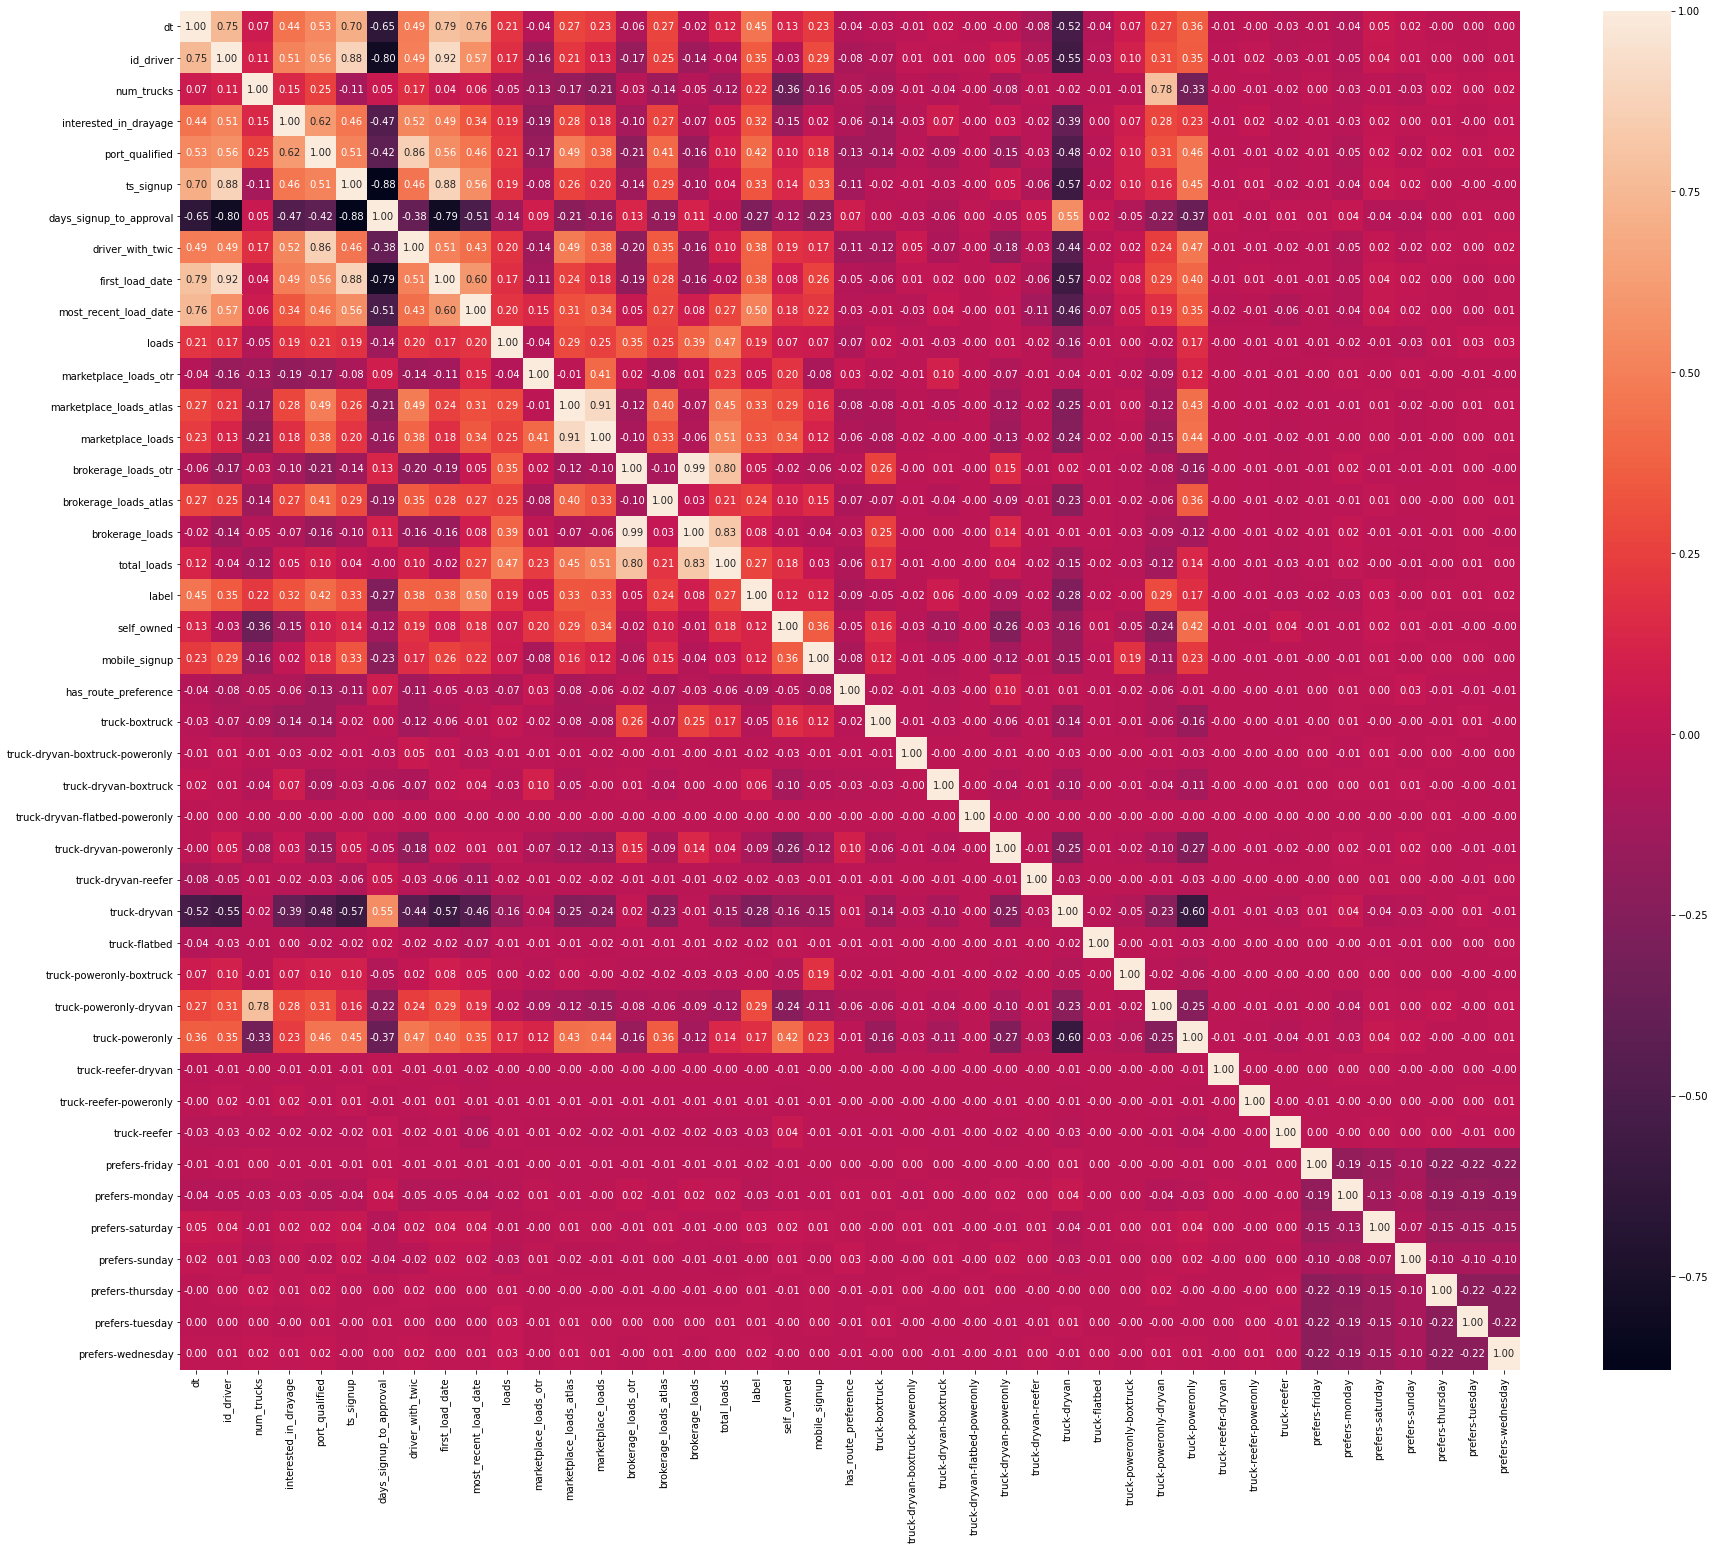

In [29]:
plt.figure(figsize=(30,25))
sn.heatmap(original_df.corr(), annot=True, fmt=".2f")
plt.show()

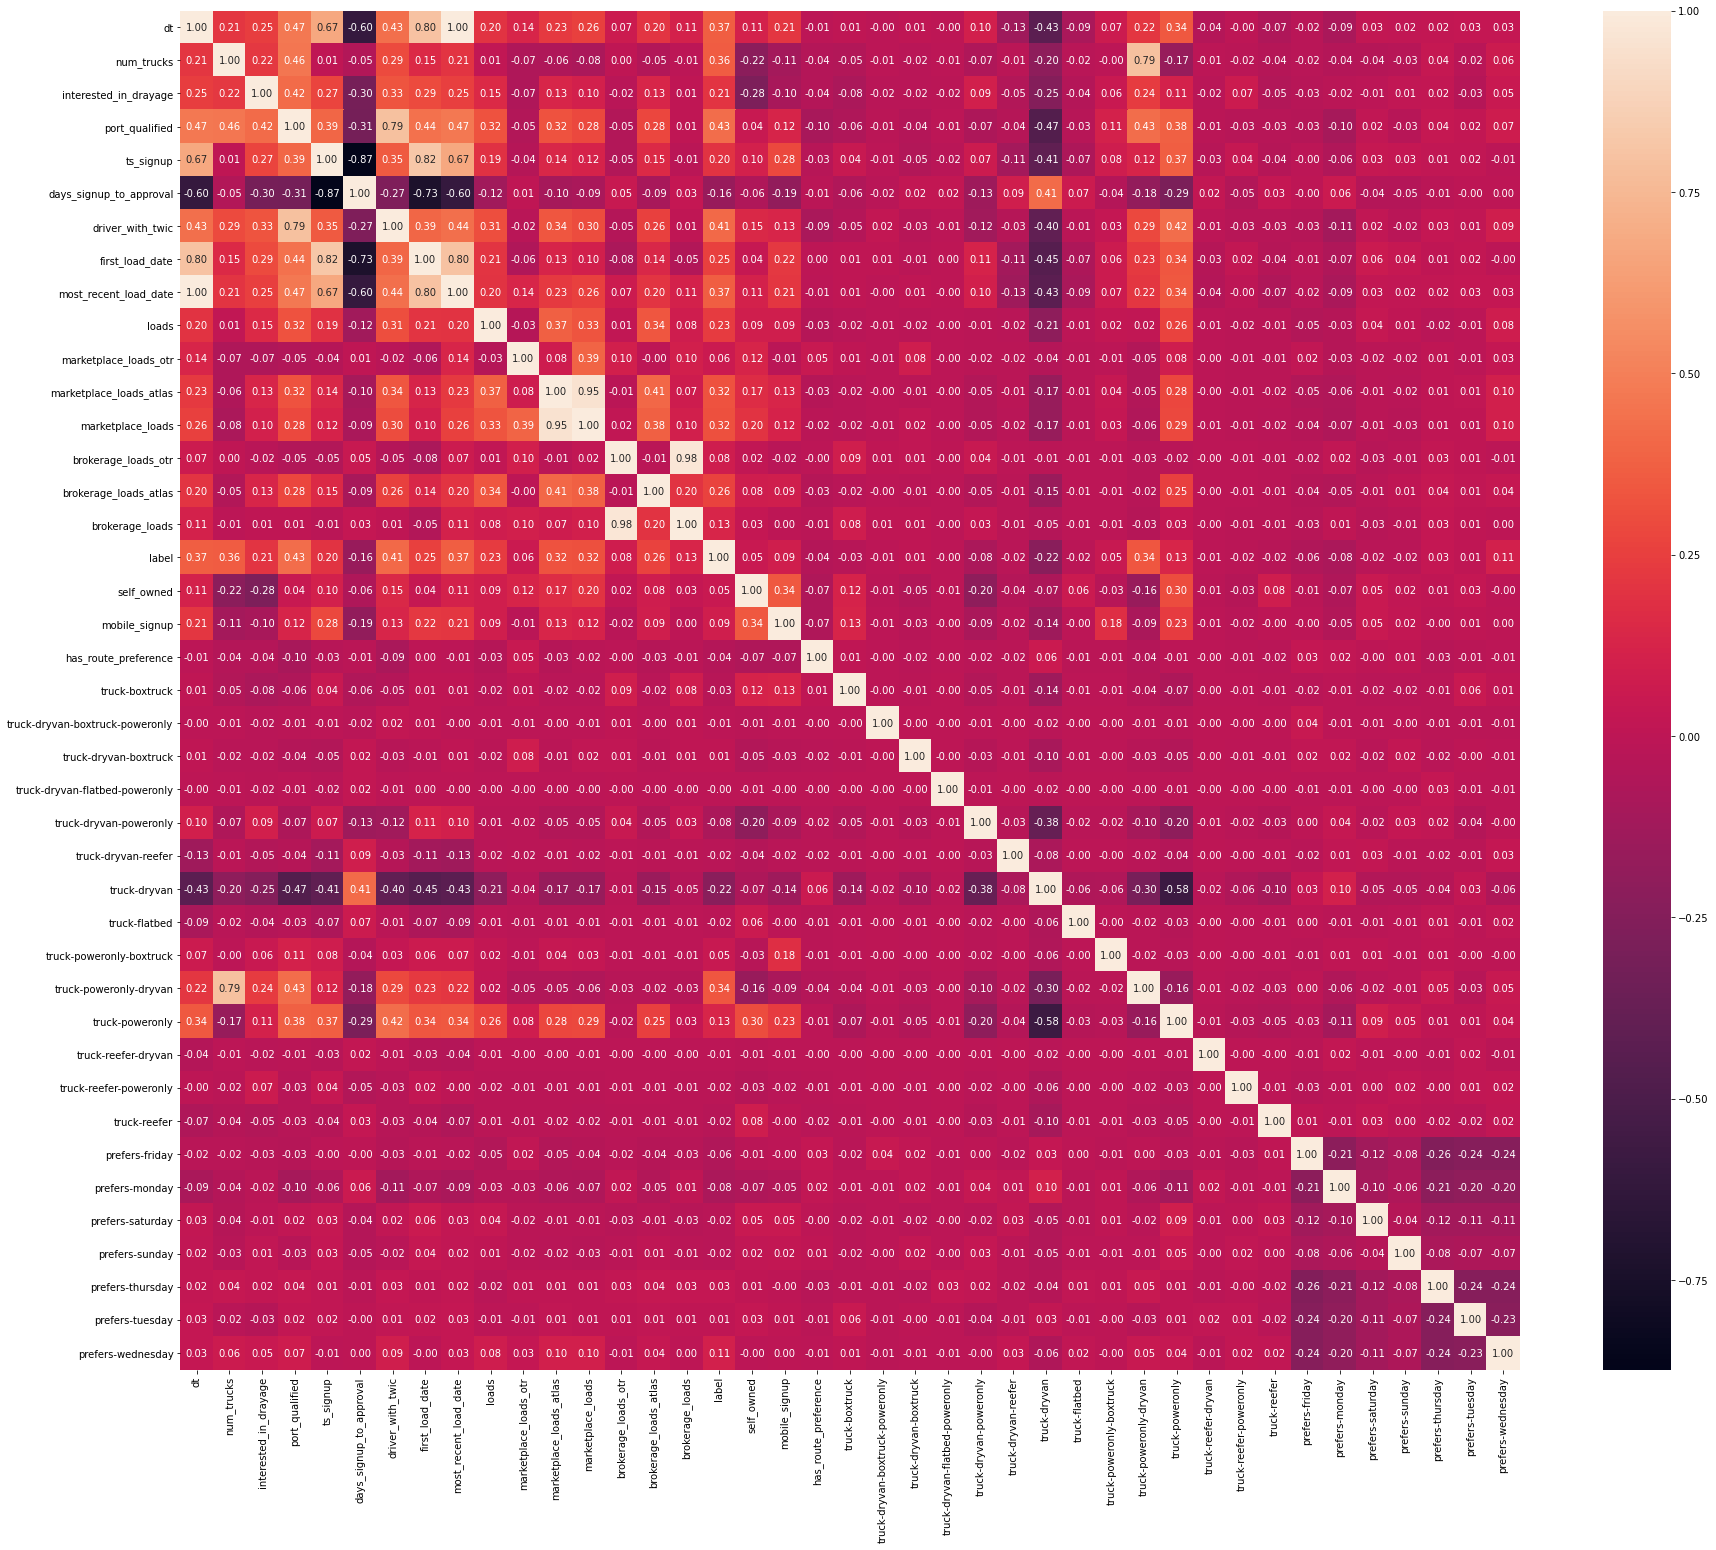

In [30]:
plt.figure(figsize=(30,25))
sn.heatmap(driver_id_df.corr(), annot=True, fmt=".2f")
plt.show()

# 5 - Linear Regression

# 6 - PCA

# 7 - Ensemble Method

# 8 - Neural Network

# 9 - Cross Validation

# 10 - Custom Model